In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 4070


In [97]:
from pathlib import Path
training_imgs = list(Path("dataset/images/train").glob("*.png"))
print(len(training_imgs))

43120


c:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\venv\lib\site-packages\albumentations\augmentations\blur\functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (4, 7) automatically adjusted to (5, 7).
  result = _ensure_odd_values(result, info.field_name)


Selected image: dataset\images\train\48_s_39_pt_ry_nt_gs_nt.png
[['0.75', '0.4473684210526316', '0.3125', '0.5263157894736842']]


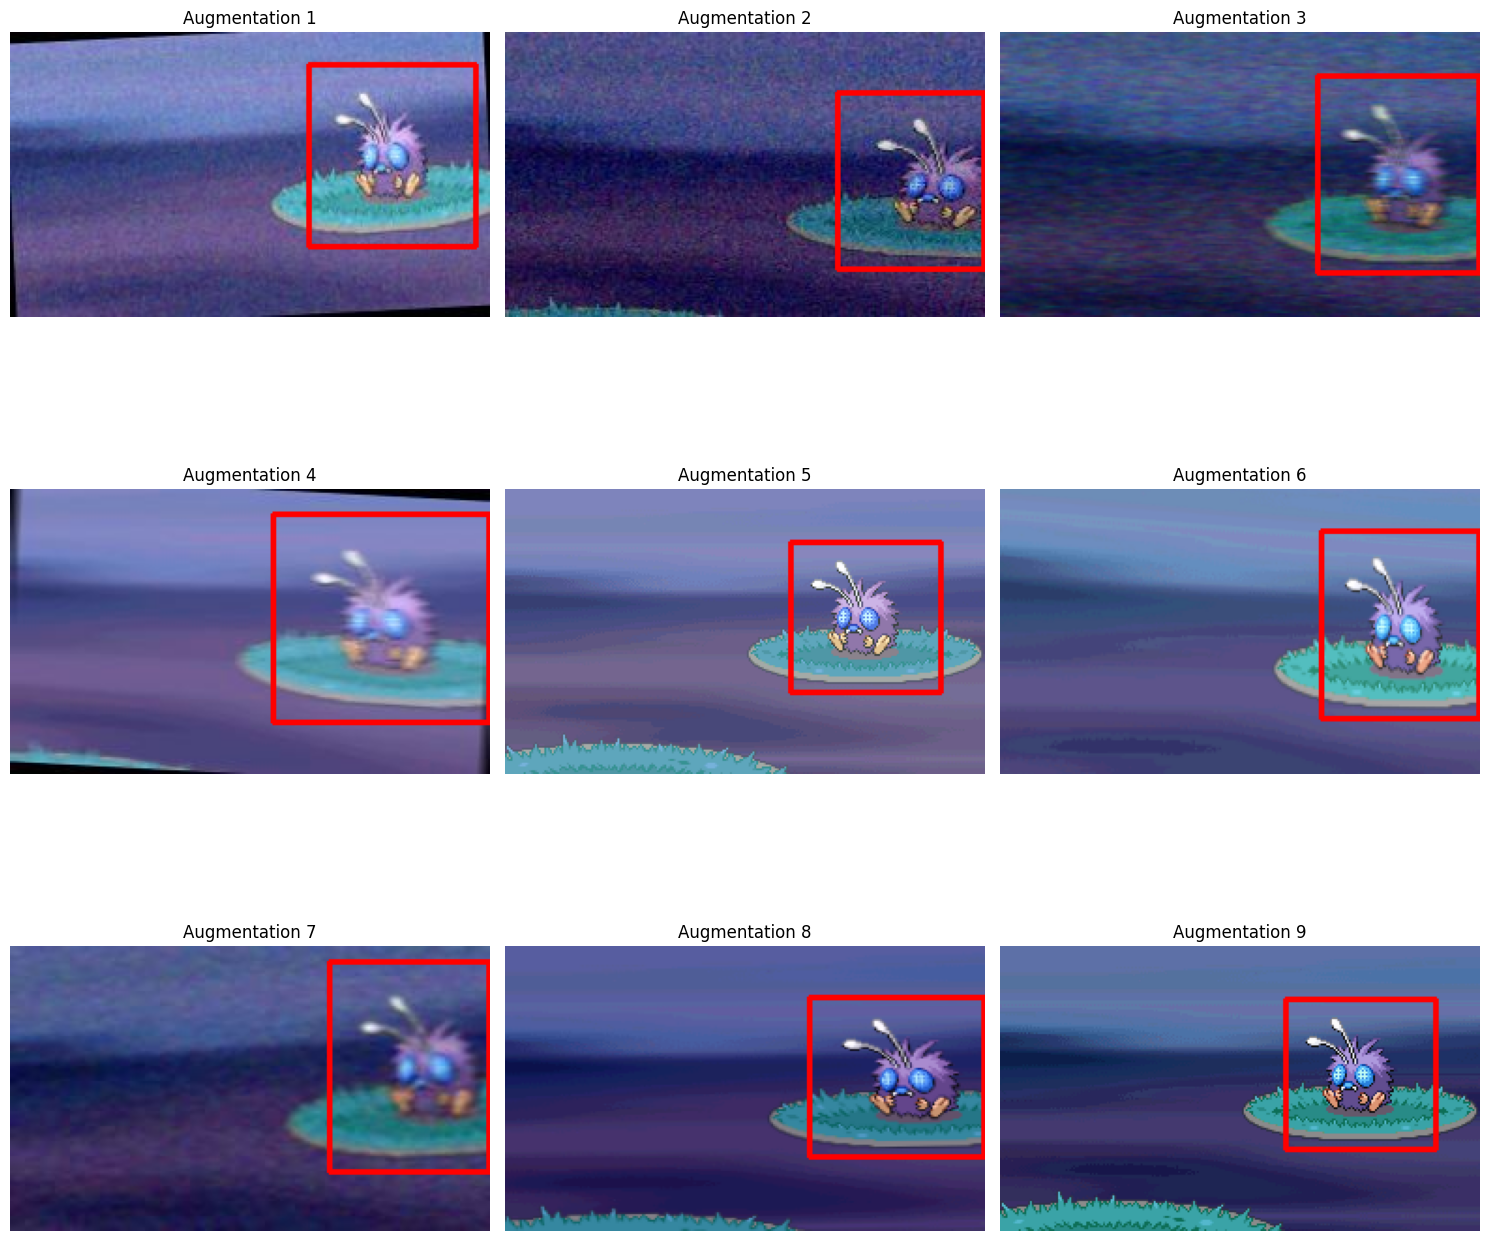

Generated 9 augmented samples
Original image shape: (152, 256, 3)


In [110]:
import random
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation pipeline
train_transform = A.Compose([
    # Screen glare and reflections
    A.RandomBrightnessContrast(
		brightness_limit=[-0.1, 0.2],
		contrast_limit=[-0.1, 0.2],
		brightness_by_max=True,
		ensure_safe_range=False,
        p=0.8
    ),
    
    # Simulate screen refresh/scan lines
    A.GaussNoise(
		std_range=[0.05, 0.1],
		mean_range=[0, 0],
		per_channel=True,
		noise_scale_factor=1,
        p=0.3
	),
    
    # Camera perspective distortion
    A.Perspective(
        scale=(0.05, 0.1),
        p=0.5
    ),
    
    # Slight rotation from handheld camera
    A.Rotate(
        limit=5,
        border_mode=0,
        p=0.5
    ),
    
    # Motion blur from hand shake
    A.MotionBlur(
		blur_limit=[4, 7],
		allow_shifted=False,
		angle_range=[0, 0],
		direction_range=[0, 0],
		p=0.3
	),
    
    # Screen color shift/white balance issues
    A.RGBShift(
        r_shift_limit=[-5, 5],
		g_shift_limit=[-5, 5],
		b_shift_limit=[-5, 5],
        p=0.5
    ),
    
    # Color temperature variations (critical for shiny detection!)
    A.HueSaturationValue(
        hue_shift_limit=[-5, 5],
        sat_shift_limit=[-5, 5],
        val_shift_limit=[-5, 5],
        p=0.7
    ),
    
    # Simulate screen brightness flickering
    A.RandomGamma(
        gamma_limit=(80, 120),
        p=0.5
    ),
    
    # Lens blur/focus issues
    A.Blur(
        blur_limit=3,
        p=0.3
    ),

    # Compression artifacts
    A.ImageCompression(
        compression_type="jpeg",
    	quality_range=[65, 95],
		p=0.4
    ),
    
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels'],
    min_visibility=0.3
))

# Function to draw bounding boxes on image
def draw_bboxes(image, bboxes, color=(0, 255, 0), thickness=2):
    """Draw YOLO format bboxes on image"""
    img_copy = image.copy()
    h, w = img_copy.shape[:2]
    
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        
        # Convert from YOLO to pixel coordinates
        x_center_px = int(x_center * w)
        y_center_px = int(y_center * h)
        box_width = int(width * w)
        box_height = int(height * h)
        
        # Calculate corner coordinates
        x1 = int(x_center_px - box_width / 2)
        y1 = int(y_center_px - box_height / 2)
        x2 = int(x_center_px + box_width / 2)
        y2 = int(y_center_px + box_height / 2)
        
        # Draw rectangle
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)
    
    return img_copy

# Load your image
image_path = random.choice(training_imgs)  # Update this path
print(f"Selected image: {image_path}")
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Example bounding boxes (YOLO format: x_center, y_center, width, height - normalized)
# Adjust these to match your actual Pokemon location
with open(f'dataset/labels/train/{image_path.stem}.txt', 'r') as f:
	lines = f.readlines()
class_label, bboxes = lines[0].split(" ", maxsplit=1) # Get the class label from the first line
class_label = [class_label]
bboxes = [[num for num in bboxes.split(" ")]]
print(bboxes)
# Generate multiple transformed versions
num_samples = 9  # 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i in range(num_samples):
    # Apply transformation
    transformed = train_transform(
        image=image,
        bboxes=bboxes,
        class_labels=class_label
    )
    
    # Draw bounding boxes on transformed image
    img_with_boxes = draw_bboxes(
        transformed['image'], 
        transformed['bboxes'],
        color=(255, 0, 0),  # Red boxes
        thickness=2
    )
    
    # Display
    axes[i].imshow(img_with_boxes)
    axes[i].axis('off')
    axes[i].set_title(f'Augmentation {i+1}')

plt.tight_layout()
plt.savefig('augmentation_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Generated {num_samples} augmented samples")
print(f"Original image shape: {image.shape}")

In [ ]:
from ultralytics import YOLO

# Only use NON-SPATIAL transforms in Albumentations
color_noise_transforms = [
    # Screen glare and reflections
    A.RandomBrightnessContrast(
        brightness_limit=[-0.1, 0.2],
        contrast_limit=[-0.1, 0.2],
        brightness_by_max=True,
        ensure_safe_range=False,
        p=0.8
    ),
    
    # Simulate screen refresh/scan lines
    A.GaussNoise(
        std_range=[0.05, 0.1],
        mean_range=[0, 0],
        per_channel=True,
        noise_scale_factor=1,
        p=0.3
    ),
    
    # Motion blur from hand shake
    A.MotionBlur(
        blur_limit=[4, 7],
        allow_shifted=False,
        angle_range=[0, 0],
        direction_range=[0, 0],
        p=0.3
    ),
    
    # Screen color shift/white balance issues
    A.RGBShift(
        r_shift_limit=[-5, 5],
        g_shift_limit=[-5, 5],
        b_shift_limit=[-5, 5],
        p=0.5
    ),
    
    # Color temperature variations
    A.HueSaturationValue(
        hue_shift_limit=[-5, 5],
        sat_shift_limit=[-5, 5],
        val_shift_limit=[-5, 5],
        p=0.7
    ),
    
    # Simulate screen brightness flickering
    A.RandomGamma(
        gamma_limit=(80, 120),
        p=0.5
    ),
    
    # Lens blur/focus issues
    A.Blur(
        blur_limit=3,
        p=0.3
    ),
    
    # Compression artifacts
    A.ImageCompression(
        compression_type="jpeg",
        quality_range=[65, 95],
        p=0.4
    ),
]

# Train with BOTH
model = YOLO("yolov8x.pt")

results = model.train(
    data="pokemon.yaml",
    epochs=100,
    patience=15,
    imgsz=256,
    batch=16,
    workers=4,
    device='cuda',
    
    # YOLO handles spatial augmentations (safe for bboxes)
    augment=True,
    degrees=5.0,
    perspective=0.00075,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    flipud=0.0,
    mosaic=0.0,
    mixup=0.0,
    
    # Albumentations handles color/noise/blur (doesn't affect bboxes)
    augmentations=color_noise_transforms,
)

New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.233  Python-3.10.11 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, augmentations=Compose([
  RandomBrightnessContrast(p=0.8, brightness_by_max=True, brightness_limit=(-0.1, 0.2), contrast_limit=(-0.1, 0.2), ensure_safe_range=False),
  GaussNoise(p=0.3, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.05, 0.1)),
  Perspective(p=0.5, border_mode=0, fill=0.0, fill_mask=0.0, fit_output=False, interpolation=1, keep_size=True, mask_interpolation=0, scale=(0.05, 0.1)),
  Rotate(p=0.5, border_mode=0, crop_border=False, fill=0.0, fill_mask=0.0, interpolation=1, limit=(-5.0, 5.0), mask_interpolation=0, rotate_method='largest_box'),
  MotionBlur(p=0.3, allow_shifted=False, angle_range=(0.0, 0.0), blur_limit=(5, 7), direction_range=(0.0, 0.0)),
  RGBShift(p=0.5, approximation=1.0,

c:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\venv\lib\site-packages\albumentations\core\composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(


val: Fast image access  (ping: 0.20.3 ms, read: 62.823.4 MB/s, size: 8.0 KB)
val: Scanning C:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\dataset\labels\val.cache... 10780 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10780/10780 5.4Mit/s 0.0s
Plotting labels to C:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to C:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\runs\detect\train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      7.32G      2.929      8.393      2.426         35        256: 0% ──────────── 1/2695 2.4it/s 0

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "c:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "c:\Users\Jason Chau\Documents\GitHub\Pokemon-CNN\venv\lib\site-packages\ultralytics\data\dataset.py", line 302, in collate_fn
    value = torch.cat(value, 0)
RuntimeError: Tensors must have same number of dimensions: got 1 and 2
